加载项

In [2]:
import numpy as np
import package
import package.optim as optim
import package.loss as loss
import sys
import router as mn
import package.draw as draw
import itertools

## 文件路径
train_file = sys.path[0]+'/MNIST/trainset.npz'
param_file = sys.path[0]+'/MNIST/param.npz'
test_file = sys.path[0]+'/MNIST/testset.npz'
record_file = sys.path[0]+'/record.txt'

## 设置网络
def quick_net(a):
    layers = [
            {'type': 'batchnorm', 'shape': 784, 'requires_grad': False, 'affine': False},
            {'type': 'linear', 'shape': (784, a)},  # 输入->第一层隐含层
            {'type': 'batchnorm', 'shape': a},
            {'type': 'relu'},
            {'type': 'linear', 'shape': (a, 10)}, # 最后一层->输出
        ]
    net = package.Net(layers)
    return net
net=quick_net(350)
## 设置损失函数
loss_fn = loss.CrossEntropyLoss()
## 设置批大小
batch_size = 128
## 设置优化器
optimizer = optim.RMSprpo(net.parameters, lr=1e-3,penalty=5e-6,decay=0.001)

最优参数下模型训练及精度

In [3]:
mn.train(net, loss_fn, train_file, batch_size, optimizer,\
    load_file=None, save_path=param_file, times=4,silent=True)
tacc,tloss=mn.test(net,loss_fn,test_file,None)


测试集准确率:96.70%


网络性能

In [3]:
from router import *
## 修改train函数，使迭代中记录可视化信息
def train_vis(net, loss_fn, train_file,test_file, batch_size, optimizer, load_file=None,\
     save_path=None, times=1,go_on=False,silent=False):
    X, Y = load_MNIST(train_file, transform=True)   # 加载训练样本和真实标签
    Xt, Yt = load_MNIST(test_file, transform=True)
    data_size = X.shape[0]   # 样本数
    ## 如果属于继续训练就加载参数
    if go_on and load_file is not None and os.path.isfile(load_file): load(net.parameters, load_file) 
    ## 根据times轮次设置循环数
    trainacc=[];testloss=[];testacc=[]
    for loop in range(times):  
        i = 0 # i 为样本中该轮已经训练过的数量
        ## 按batch_size分批训练
        while i <= data_size - batch_size:
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            ## 前向传播
            output = net.forward(x)  
            ## 根据损失函数计算损失            
            batch_acc, batch_loss = loss_fn(output, y)  
            # print(batch_loss)
            ## 梯度反向传播
            eta = loss_fn.gradient()
            net.backward(eta)
            ## 用优化器进行参数学习
            optimizer.update()
            ## 记录可视化信息
            train_acc,_=test(net,loss_fn,get=[X,Y],silent=True)
            test_acc,test_loss=test(net,loss_fn,get=[Xt,Yt],silent=True)
            trainacc.append(train_acc)
            testacc.append(test_acc)
            testloss.append(test_loss)
            ## 每50次迭代打印以下训练信息
            if i % 50 == 0 and not silent:
                print("loop: %d, batch: %5d, batch acc: %2.1f, batch loss: %.2f" % \
                    (loop+1, i, batch_acc*100, batch_loss))
    ## 如果传入保存路径，就对参数进行保存
    if save_path is not None: save(net.parameters, save_path)
    return trainacc,testacc,testloss

a,b,c=train_vis(net, loss_fn, train_file,test_file, batch_size, optimizer,times=2,silent=True)
np.savez(sys.path[0]+'/MNIST/plotinfo',trainacc=a,testacc=b,testloss=c)
# 注：这一代码块相当慢

In [ ]:
%config InlineBackend.figure_format = 'svg'
from package.draw import draw_ts
import pylab
pylab.rcParams['figure.figsize'] = (5.0, 3.0) # 显示大小
file=np.load(sys.path[0]+'/MNIST/plotinfo.npz')
a=file['trainacc'];b=file['testacc'];c=file['testloss']
draw_ts([a,b],['训练集精度','测试集精度'])
draw_ts([c],['测试集损失'])

网络参数可视化

In [3]:
%config InlineBackend.figure_format = 'svg'
from package.draw import draw_ts
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pylab
pylab.rcParams['figure.figsize'] = (5.0, 3.0) # 显示大小
net=quick_net(350)
mn.load(net.parameters, param_file) 
W=mn.read_weight(net.parameters)
W1 = W[0]
W2 = W[2]
pca = PCA(n_components=10)
pca.fit(W1)
pca_W1 = pca.fit_transform(W1)

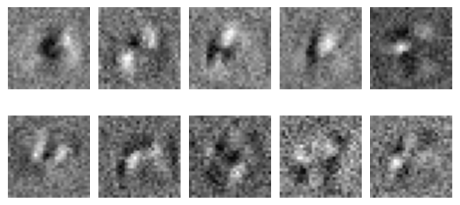

In [54]:
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (8.0, 4.0) # 显示大小
plt.subplots_adjust(hspace=0, wspace=0.1)
for i in range(pca_W1.shape[1]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca_W1[:, i].reshape(28, 28,order='F'), cmap ='gray')
    plt.axis('off')

plt.show()

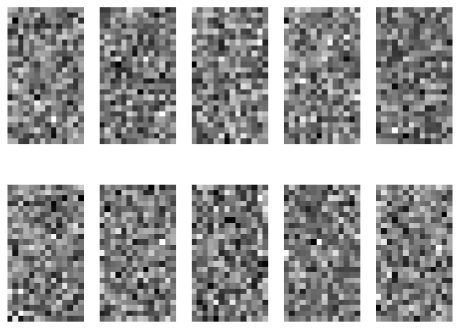

In [58]:
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (8.0, 6.0) # 显示大小
for i in range(W2.shape[1]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(W2[:, i].reshape(25,14), cmap ='gray')
    plt.axis('off')
plt.show()

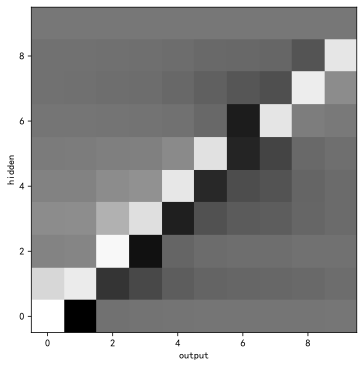

In [57]:
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (8.0, 6.0) # 显示大小
nW2=pca.fit_transform(W2.T).T
plt.imshow(nW2,cmap='gray')
# plt.axis('off')
plt.ylabel('hidden')
plt.xlabel('output')
plt.gca().invert_yaxis()
plt.show()